# Flux Light-Curve (4C+21.35, noflare)

**To run this, you need the following files, which can be downloaded using the first few cells of this notebook:**
- orientation file (COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori)       
- download unbinned data (COSI-SMEX/DC3/Data/Sources/4C21p35_flare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Sources/4C21p35_noflare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Backgrounds/Ge/AlbedoPhotons_3months_unbinned_data_filtered_with_SAAcut.fits.gz), combine with background and binning     
- detector response (COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip)     

**The binned data are simulations of the 4C+21.35 (noflare) and albedo photon background produced using the COSI SMEX mass model. The detector response needs to be unzipped before running the notebook.**

This notebook slices the COSI dataset (4C+21.35, noflare) into time slices, using a criteria (i.e. equal length slices). Perform a fit with [3ML](https://threeml.readthedocs.io/) in each of them. It finally examines the time series of flux and fitted spectral parameters. For each slicing case, it saves: a txt file of the raw lightcurves (lc.dat); a plot at each iteration of the fit (fit_i.pdf); a txt file (spec_lc.dat) including the mid-point of each time bin with errors, the total counts, the fluxes with asymmetric errors, the fitted parameters with symmetric errors; two plots (raw_flux_counts_lc.pdf, specpars_bk_lc.pdf) of the final time series.

In [1]:
from cosipy import COSILike, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.util import fetch_wasabi_file

from scoords import SpacecraftFrame

from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import poisson_conf_interval

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from threeML import *
from threeML import Band, PointSource, Model, JointLikelihood, DataList
from cosipy import Band_Eflux
from astromodels import Parameter

from pathlib import Path

import os
import subprocess
import corner
from astromodels import *


10:29:24 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=44745;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=494653;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#47\47]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=873428;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=400489;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#68\68]8;;\
                  will not be available.                                                                           

10:29:25 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=963039;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=708901;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=193714;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=724442;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=49485;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=56458;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=806902;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=275992;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=999599;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=470626;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

10:29:25 WARNING   ROOT minimizer not available                                                ]8;id=217085;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=878082;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=732874;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=719620;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=865130;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=57475;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=130988;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=406876;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=393670;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=431016;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=946474;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=731402;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=446602;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=622895;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=670953;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=395584;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=338925;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=176277;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=483245;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=831143;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## A simple function to create equal sized time slices.


This function slices a time interval in N bins.

In [2]:
"""
INPUT:
tstart, tstop: edges of the time interval to be sliced.
nbins: number of bins to create.
OUTPUT:
tmins,tmaxs: arrays containing the edges of the slices.
"""
def make_eqsize_tslices(tstart,tstop,nbins):
    dt=(tstop-tstart)/nbins
    tmins = np.array([], dtype=float)# Initialize as empty numpy arrays
    tmaxs=np.array([], dtype=float)# Initialize as empty numpy arrays
    #
    for i in range(nbins):
        tmin=tstart+i*dt
        tmax=tmin+dt
        tmins = np.append(tmins, tmin)
        tmaxs=np.append(tmaxs, tmax)
    return(tmins,tmaxs)




## Download and read in binned data

Define the path to the directory containing the data, detector response, orientation file, and yaml files if they have already been downloaded, or the directory to download the files into. Define a directory where you want to save the outputs. Defaults are ./cosidata and ./cosiprod

In [3]:
# current=os.getcwd()
# indir=str(current+"/cosidata")
# data_path = Path(indir)
# odir= str(current+"/cosiprod")
data_path = Path("/home/srinadb/cosipy/docs/tutorials/spectral_fits/dataset/")

Download the orientation file (684.38 MB)

In [4]:
#fetch_wasabi_file('COSI-SMEX/DC2/Data/Orientation/20280301_3_month_with_orbital_info.ori', output=str(data_path / '20280301_3_month_with_orbital_info.ori'))

Download the binned GRB+background data (75.73 KB)

In [5]:
#fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/grb_spectral_fit_local_frame/grb_bkg_binned_data.hdf5', output=str(data_path / 'grb_bkg_binned_data.hdf5'))

Download the binned GRB data (76.90 KB)

In [6]:
#fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/grb_spectral_fit_local_frame/grb_binned_data.hdf5', output=str(data_path / 'grb_binned_data.hdf5'))

Download the binned background data (255.97 MB)

In [7]:
#fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/grb_spectral_fit_local_frame/bkg_binned_data_1s_local.hdf5', output=str(data_path / 'bkg_binned_data_1s_local.hdf5'))

Download the response file (839.62 MB) and unzip it in indir.

In [8]:
#
#fetch_wasabi_file('COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip', output=str(data_path / 'SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip'))
#
#filename="SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip"
#filepath = os.path.join(indir, filename)
#Unzip
#subprocess.run(["unzip", filepath])
#

Create BinnedData objects for the Crab only, Crab+background, and background only. The Crab only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [4]:
blazar = BinnedData("blazar.yaml")
blazar_bkg = BinnedData("blazar.yaml")
bkg = BinnedData("background.yaml")

Load binned .hdf5 files

In [5]:
blazar.load_binned_data_from_hdf5(binned_data="./4C21p35_noflare_binned_data.hdf5")
blazar_bkg.load_binned_data_from_hdf5(binned_data="./4C21p35_noflare_AlbedoPhoton_bkg_binned_data.hdf5")
bkg.load_binned_data_from_hdf5(binned_data="./AlbedoPhoton_bkg_binned_data.hdf5")

Define the path to the detector response

In [6]:
dr = str(data_path / "ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5") # path to detector response
ori = SpacecraftFile.parse_from_file(data_path / "DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori")


Define the path the injected spectral model, and inizialize the parameters of the fits to something reasonable.

In [7]:
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/Extragalactic/4C21p35/4C21p35.source

l = 255.073637
b = 81.659766

index = -1.0
piv = 1e6 * u.keV
K = 1.52e-10 / u.cm / u.cm / u.s / u.keV # 2.6754e-12

spectrum = Powerlaw()

spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value

spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit


Find time window of the Crab data and make a raw lightcurve to be plotted as a comparison.

In [8]:
blazar_bkg.get_raw_lightcurve(binned_data="./4C21p35_noflare_AlbedoPhoton_bkg_binned_data.hdf5", output_name="lc_blazar_noflare")
time, rate = np.loadtxt("lc_blazar_noflare.dat", skiprows=1, unpack=True)
tstart=np.min(time)
tstop=np.max(time)


# Time series in equal size time slices



Now we use either the make_eqsize_tbins to determine the edges of N time slices. We used them to slice the data in time. We perform N spectral fits to determine fluxes and spectral parameters as a function of time. We save a plot of the fit at each iteration, to allow the user to inspect the goodness of the fit. We save all the time series in a text file.

10:32:36 INFO      set the minimizer to minuit                                             ]8;id=887885;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=943212;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


10:33:35 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=976970;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=289305;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(0.8 -0.5 +1.1) x 10^-11,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-1.38 +/- 0.10,
background_cosi,(3.3331 +/- 0.0015) x 10^-1,


Correlation matrix:

1.00,0.98,-0.39
0.98,1.00,-0.27
-0.39,-0.27,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-3.312779e+07
total,-3.312779e+07


Values of statistical measures:

,statistical measures
AIC,-6.625557e+07
BIC,-6.625557e+07


processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

10:34:47 INFO      set the minimizer to minuit                                             ]8;id=909551;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=846488;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


10:36:13 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=806758;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=883223;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(0.021 -0.021 +2.8) x 10^-6,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,(2 +/- 9) x 10^-1,
background_cosi,(3.3238 +/- 0.0011) x 10^-1,


Correlation matrix:

1.00,0.98,0.08
0.98,1.00,0.14
0.08,0.14,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-3.293897e+07
total,-3.293897e+07


Values of statistical measures:

,statistical measures
AIC,-6.587795e+07
BIC,-6.587794e+07


processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

10:37:20 INFO      set the minimizer to minuit                                             ]8;id=500270;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=805826;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


10:38:02 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=206882;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=766039;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(2.1 -1.5 +5) x 10^-12,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-1.59 +/- 0.15,
background_cosi,(3.3218 +/- 0.0016) x 10^-1,


Correlation matrix:

1.00,1.00,-0.57
1.00,1.00,-0.52
-0.57,-0.52,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-3.299731e+07
total,-3.299731e+07


Values of statistical measures:

,statistical measures
AIC,-6.599462e+07
BIC,-6.599462e+07


processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

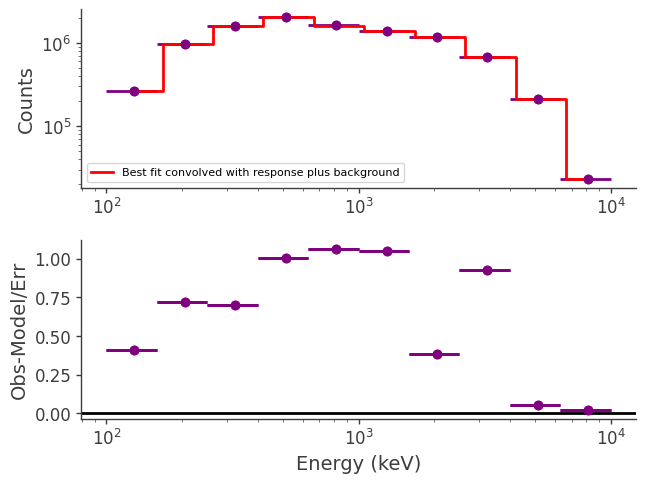

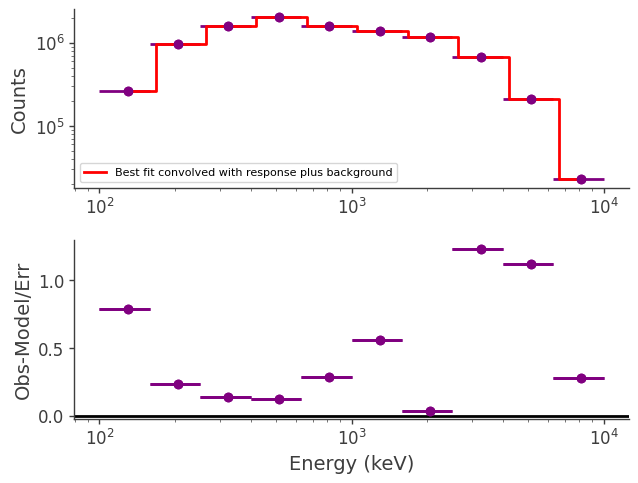

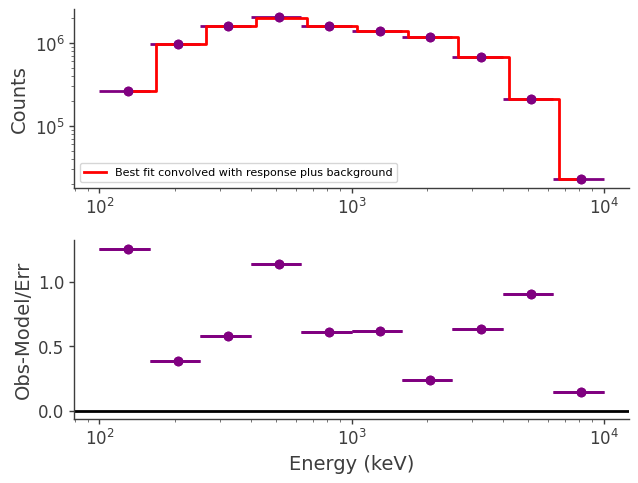

In [9]:
#Create equal sized time slices. Change nslices as you wish to make less or more slices.
nslices=3
tmins,tmaxs=make_eqsize_tslices(tstart,tstop,nslices)
#
#Initialize empty vectors that will be filled at each step.
#
tmins_lc=np.array([])
tmaxs_lc=np.array([])
tmeds_lc=np.array([])
e_tmeds_lc=np.array([])
#
cts_lc=np.array([])
fls=np.array([])
e_low_fls=np.array([])
e_hi_fls=np.array([])
#
flse=np.array([])
e_low_flse=np.array([])
e_hi_flse=np.array([])

pars_bk=np.array([])
epars_bk=np.array([])
#
par_epar=np.array([])
#
for i in range(len(tmaxs)):
    #
    #LOOP over our N time bins.
    #
    #Slice the orientation file into the time interval
    #
    ori_min = Time(tmins[i],format = 'unix')
    ori_max = Time(tmaxs[i],format = 'unix')
    sc_orientation = ori.source_interval(ori_min, ori_max)
    #
    #
    #Find the index of time axes corresponding to the limits of the tmins[i],tmaxs[i].
    #These are used to slice the data in time in the fit setup.
    #
    sou_min = np.where(blazar_bkg.binned_data.axes['Time'].edges.value >= tmins[i])[0][0]
    sou_max_all = np.where(blazar_bkg.binned_data.axes['Time'].edges.value <= tmaxs[i])
    y=len(sou_max_all[0])-1
    sou_max=np.where(blazar_bkg.binned_data.axes['Time'].edges.value <= tmaxs[i])[0][y]
    #
    #Save the time bin edges and middle points for plotting later.
    #
    tmin_lc=blazar_bkg.binned_data.axes['Time'].edges.value[sou_min]
    tmins_lc=np.append(tmins_lc,tmin_lc)
    #
    tmax_lc=blazar_bkg.binned_data.axes['Time'].edges.value[sou_max]
    tmaxs_lc=np.append(tmaxs_lc,tmax_lc)
    #
    dt=(tmax_lc-tmin_lc) #total duration of the time bin
    tmed_lc=tmin_lc+0.5*dt#midpoint of time bins
    tmeds_lc=np.append(tmeds_lc,tmed_lc)#midpoints of the time bin
    hdt=dt/2 #half duration of the time bin i.e symmetric error for t_med
    e_tmeds_lc=np.append(e_tmeds_lc,hdt)#half duration of the time bin i.e symmetric error for t_med
    #
    #Define the background parameters
    #
    #
    bkg_par = Parameter("background_cosi",                                         # background parameter
                     1,                                                        # initial value of parameter
                     min_value=0,                                              # minimum value of parameter
                     max_value=5,                                              # maximum value of parameter
                     delta=0.05,                                               # initial step used by fitting engine
                     desc="Background parameter for cosi")
#
    #
    #HERE's the key point. In the fit setup data, the grb_bkg data are sliced in Time in the interval tmins[i],tmaxs[i]
    #
    cosi = COSILike("cosi",                                                        # COSI 3ML plugin
                 dr = dr,                                                      # detector response
                 data = blazar_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}].project('Em', 'Phi', 'PsiChi'),   # data (source+background)
                 bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                 sc_orientation = sc_orientation,                              # spacecraft orientation
                 nuisance_param = bkg_par)                                     # background parameter
    
    #
    
    source = PointSource("source",                 # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

    model = Model(source)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

    # Optional: if you want to call get_log_like manually, then you also need to set the model manually
    # 3ML does this internally during the fit though
    cosi.set_model(model)    
    plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)
    #
    like = JointLikelihood(model, plugins, verbose = False)
    like.fit()
    results = like.results
    #
    #
    #Obtain counts in time slices:
    #
    cts=np.sum(blazar_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}])
    cts_lc=np.append(cts_lc,cts)
    #
    #Obtain parameters:
    #
    #bk
    #
    par_bk=results.get_variates("background_cosi").median
    pars_bk=np.append(pars_bk,par_bk)
    epar_bk=results.get_variates("background_cosi").std
    epars_bk=np.append(epars_bk,epar_bk)   
    #
    #These are dictionaries of parameters values and errors.
    #
    par_bf= {par.name:results.get_variates(par.path).median
                  for par in results.optimized_model["source"].parameters.values()
                  if par.free}
    #
    epar_bf= {par.name:results.get_variates(par.path).std
                  for par in results.optimized_model["source"].parameters.values()
                  if par.free}
    #
    par_list = list(par_bf.keys()) #This is a list of the parameter names.
    for j in range(len(par_list)):
        par_epar=np.append(par_epar,par_bf[par_list[j]])
        par_epar=np.append(par_epar,epar_bf[par_list[j]])         
    #
    #Obtain fluxes:
    #Here I use the 3ML method to ge integrated flux in an energy range.
    #I use the energy range from the data 100--10000 keV
    #
    # figure = corner.corner(results.samples.T, labels=["K", "index", "B"], label_kwargs={"color": "red"}, quantiles=(0.16, 0.5, 0.84), levels=(0.68,))

    threeML_config.point_source.integrate_flux_method = "trapz"
    result_fl=results.get_flux(
        ene_min=100. * u.keV,
        ene_max= 10000.* u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)"
    )
    result_fle=results.get_flux(
        ene_min=100. * u.keV,
        ene_max= 10000.* u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="erg/(cm2 s)"
    )
    #
    fl=result_fl["flux"].values[0].value
    fls=np.append(fls,fl)
    e_low_fl=np.abs(result_fl["low bound"].values[0].value-fl)
    e_low_fls=np.append(e_low_fls, e_low_fl)
    e_hi_fl=result_fl["hi bound"].values[0].value-fl
    e_hi_fls=np.append(e_hi_fls, e_hi_fl)
    #
    fle=result_fle["flux"].values[0].value
    flse=np.append(flse,fle)
    e_low_fle=np.abs(result_fle["low bound"].values[0].value-fle)
    e_low_flse=np.append(e_low_flse, e_low_fle)
    e_hi_fle=result_fle["hi bound"].values[0].value-fle
    e_hi_flse=np.append(e_hi_flse, e_hi_fle)
    
    #
    #Save a plot of the current fit.
    #
    ene = np.array([])
    e_ene = np.array([])
    #
    binned_energy_edges = blazar.binned_data.axes['Em'].edges.value
    for j in range(len(binned_energy_edges) - 1):
        delta_ene=(binned_energy_edges[j + 1]-binned_energy_edges[j])
        ene= np.append(ene, (binned_energy_edges[j]+0.5*delta_ene))
        e_ene = np.append(e_ene, 0.5*delta_ene)
    #
    #
    cts_obs=blazar_bkg.binned_data.slice[{'Time':slice(sou_min,sou_max)}].project('Em').todense().contents
    e_cts_obs=np.sqrt(cts_obs)
    #
    expectation = cosi._expected_counts['source']
    cts_exp=expectation.project('Em').todense().contents + (bkg_par.value * bkg.binned_data.project('Em').todense().contents)
    #
    resid=resid = np.abs((cts_obs - cts_exp) / e_cts_obs)
    e_resid=(e_cts_obs/cts_obs)*resid
    #
    # cm = 1 / 2.54
    #
    fig, ax = plt.subplots(2, 1)
    # , sharex=True, gridspec_kw={'height_ratios': [0.7, 0.3]})
    fig.tight_layout()
    #
    ax[0].scatter(ene, cts_obs, color='purple')
    ax[0].errorbar(ene, cts_obs, xerr=e_ene, yerr=e_cts_obs, color='purple', fmt='o', capsize=0)
    #
    ax[0].step(ene, cts_exp, where='mid', color='red', label="Best fit convolved with response plus background")
    #
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].set_ylabel("Counts")
    ax[0].legend()
    #
    #
    #
    ax[1].errorbar(ene, resid, xerr=e_ene, yerr=e_resid, color='purple', fmt='o', capsize=0)
    ax[1].errorbar(ene, resid, xerr=e_ene, yerr=e_resid, color='purple', fmt='o', capsize=0)
    ax[1].axhline(y=0, color='black')
    ax[1].set_xscale("log")
    ax[1].set_yscale("linear")
    ax[1].set_ylabel("Obs-Model/Err")
    ax[1].set_xlabel("Energy (keV)")
    #
    os.makedirs("plots", exist_ok=True)  # Create directory first
    plt.savefig(f"plots/eqslice_fit_{i:03d}.png", dpi=300, bbox_inches='tight')
#
#Save lc in in a text file:
#
lc=np.vstack((tmeds_lc,e_tmeds_lc,cts_lc,fls,e_low_fls,e_hi_fls,flse,e_low_flse,e_hi_flse,pars_bk,epars_bk)).T
nbins=len(tmeds_lc)
npars=2*len(par_list)
lc_par=par_epar.reshape(nbins,npars)
lc_all=np.hstack((lc,lc_par))
fl_list=['t','e_t','cts','fl','e+_fl','e-_fl','bk','e_bk']
par_list = list(par_bf.keys())
header=fl_list+par_list
np.savetxt("eqslice_spec_lc_blazar_noflare.dat", lc_all, delimiter=" ",header=str(header))


## Plotting the time series.

Now we plot the time-series of fluxes, counts and fitted parameters. We convert the time in mjd for plotting. 
We use the raw lightcurve and the average flux injected as comparison. We plot the counts in each time bins to check that the fits had a reasonable statistics. In the future, we may be able to compute a goodness of fit in each time bin with 3ML. The average photon flux in the 0.1-10 MeV energy range, in photon/cm2/s,for a Comptonized model fit 
to a single spectrum over the duration of the burst is taken from the input files for DC3 simulations.

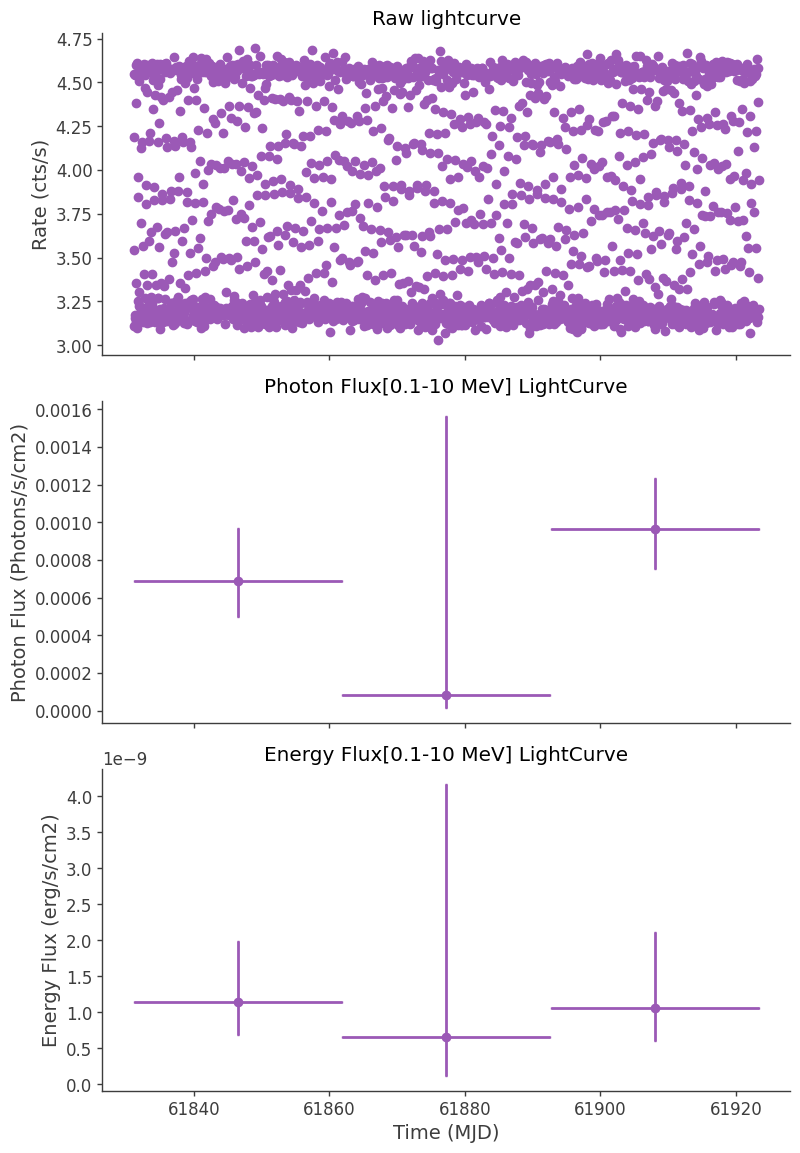

In [10]:
#
#Plot the time series of counts and fluxes
#
time_mjd=Time(time,format='unix').mjd
tmeds_mjd=Time(tmeds_lc, format='unix').mjd
e_tmeds_mjd=TimeDelta(e_tmeds_lc, format='sec').to('day').value
simulated_flux=0.0005535336

cm = 1/2.54
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(21*cm, 29.7*cm))
#
# Raw Lightcurve
axs[0].scatter (time_mjd, rate)
axs[0].set_title('Raw lightcurve')
axs[0].set_ylabel('Rate (cts/s)')
#
# Photon Flux Lightcurve
axs[1].errorbar(tmeds_mjd, fls, xerr=e_tmeds_mjd, yerr=[e_low_fls,e_hi_fls],fmt='o', capsize=1)
axs[1].set_title('Photon Flux[0.1-10 MeV] LightCurve')
axs[1].set_ylabel('Photon Flux (Photons/s/cm2)')
# axs[1].axhline(y=simulated_flux, color='red', linestyle='--')
#
# Photon Flux Lightcurve
axs[2].errorbar(tmeds_mjd, flse, xerr=e_tmeds_mjd, yerr=[e_low_flse,e_hi_flse],fmt='o', capsize=1)
axs[2].set_title('Energy Flux[0.1-10 MeV] LightCurve')
axs[2].set_ylabel('Energy Flux (erg/s/cm2)')
axs[2].set_xlabel('Time (MJD)')
# axs[2].axhline(y=simulated_flux, color='red', linestyle='--')
#
#Counts in log scale. To check that the fits have reasonable statistics.
# axs[3].set_yscale('log')
# axs[3].step(tmeds_mjd, cts_lc, where='mid',color='purple')
# axs[3].errorbar (tmeds_mjd, cts_lc,xerr=e_tmeds_mjd,fmt='o', capsize=1)
# axs[3].set_title('Counts')
# axs[3].set_xlabel('Time (MJD)')
# axs[3].axhline(y=1, color='red', linestyle='--')
#

#
# Adjust spacing between subplots
plt.tight_layout()
# plt.savefig("eqslice_raw_flux_counts_lc.pdf", dpi=300)
os.makedirs("plots", exist_ok=True)  # Create directory first
plt.savefig(f"eqslice_raw_flux_lc_blazar_noflare.png", dpi=300, bbox_inches='tight')
    

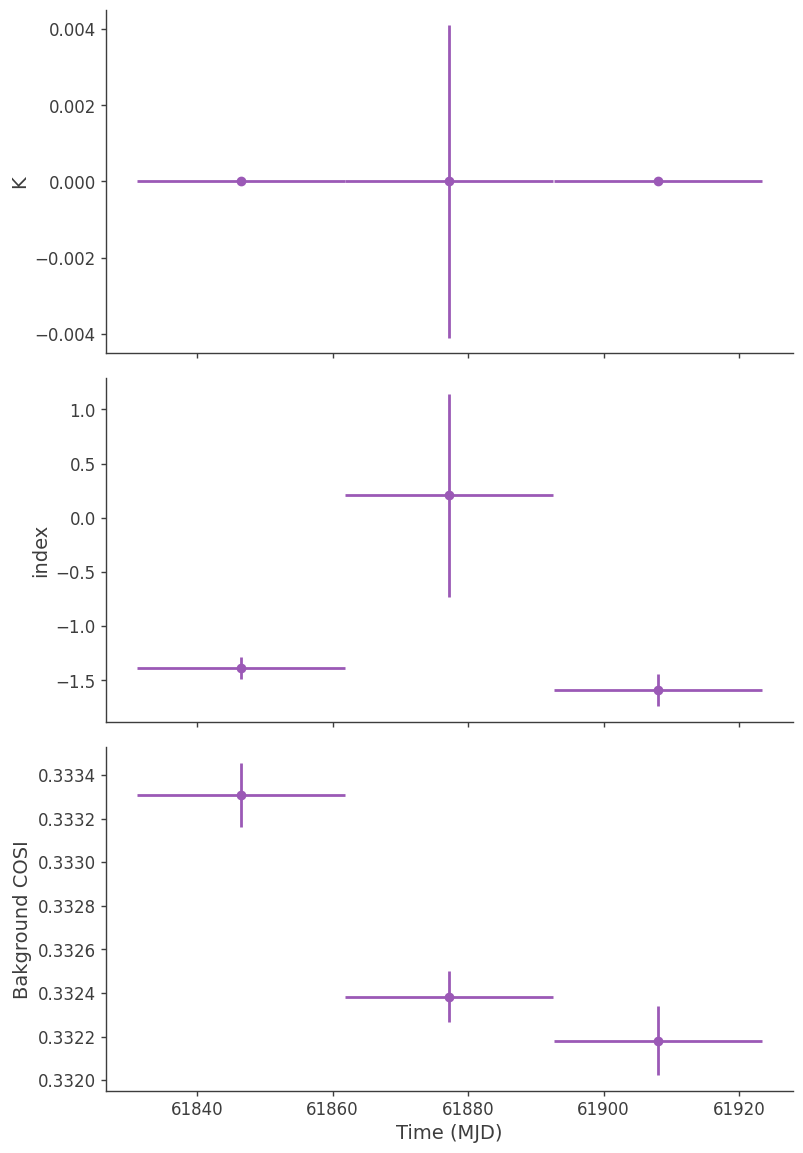

In [11]:
#
#Plot parameters as a function of time
#
npar=len(par_list)
cm = 1/2.54 
fig, axs = plt.subplots(npar+1, 1, sharex=True, figsize=(21*cm, 29.7*cm))

h=np.arange(0, 2*npar, 2)
for i in range(npar):
    axs[i].errorbar(tmeds_mjd, lc_par[:,h[i]], xerr=e_tmeds_mjd, yerr=lc_par[:,h[i]+1], fmt='o', capsize=0)
    axs[i].set_ylabel(par_list[i])

axs[npar].errorbar(tmeds_mjd, pars_bk, xerr=e_tmeds_mjd, yerr=epars_bk, fmt='o')
# axs[npar].set_title('Bakground COSI')
axs[npar].set_xlabel('Time (MJD)')
axs[npar].set_ylabel('Bakground COSI')

# Adjust spacing between subplots
plt.tight_layout()
# plt.savefig("eqslice_specpars_bk_lc.pdf", dpi=300)
os.makedirs("plots", exist_ok=True)  # Create directory first
plt.savefig(f"eqslice_specpars_bk_lc_blazar_noflare.png", dpi=300, bbox_inches='tight')


In [16]:
# time_in_seconds = np.array(time)

# SECONDS_PER_DAY = 86400.0

# # Calculate the offset in days (which is the MJD offset)
# mjd_offsets = time_in_seconds / SECONDS_PER_DAY

# # print("Time (s) | MJD Offset from Start")
# print("---------|----------------------")
# # for t_sec, mjd_off in zip(time_in_seconds, mjd_offsets):
#     # print(f"{t_sec:<9.1f}| {mjd_off:.8f}")

# # The actual MJD would be MJD_start + mjd_offsets
# # print("\nArray of MJD offsets:")
# # print(mjd_offsets)

---------|----------------------


Integral: 400388.9525220356
1/dt * Integral: 0.05017443145212064



WARNING ErfaWarning: ERFA function "taiutc" yielded 531997 of "dubious year (Note 4)"



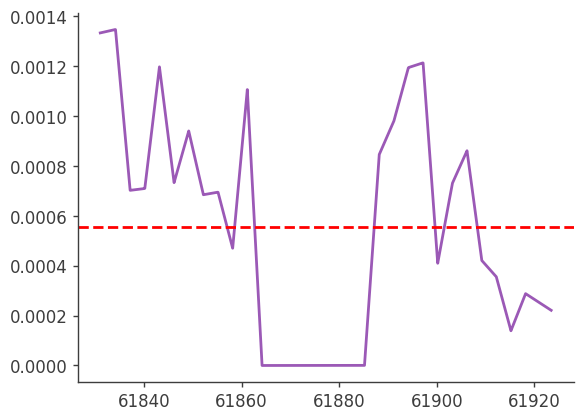

In [12]:

time_l = []
norm = []
with open('./4C_21_lightcurve_noflare.dat', 'r') as file:
    lines = file.readlines()

for line in lines[2:]:
    tokens = line.split()  # split by whitespace
    if len(tokens) >= 3:   # we expect at least 3 tokens per data row
        try:
            # tokens[2] should be the relative value (e.g. "9.2e+00")
            value1 = float(tokens[1])
            value2 = float(tokens[2])
            time_l.append(value1)
            norm.append(value2)
        except ValueError:
            # If conversion fails, skip this line
            continue

dt = time_l[-1] - time_l[0]
I = np.trapz(norm, time_l)  # numerical integral using trapezoidal rule
avg_norm = I / dt
print("Integral:", I)
print("1/dt * Integral:", avg_norm)
flux = 0.0005535336768481181 
fact = flux/avg_norm
norm = np.array(norm)  # convert list to numpy array
flux_i = norm*fact

# The Unix timestamp corresponding to the 0.0 offset in your list
start_unix_time_val = time_l[0]
# 1835489099.7192152

start_time = Time(start_unix_time_val, format='unix', scale='utc')

time_deltas = TimeDelta(time_l * u.s) # Use astropy units for clarity

absolute_times = start_time + time_deltas

# mjd_values = absolute_times.mjd
mjd_values = Time(time_l,format='unix').mjd

plt.plot(mjd_values, flux_i)
# axs[1].axhline(y=simulated_flux, color='red', linestyle='--')
plt.axhline(y=simulated_flux, color='red', linestyle='--')
plt.savefig(f"plots/original_lc.png", dpi=300, bbox_inches='tight')


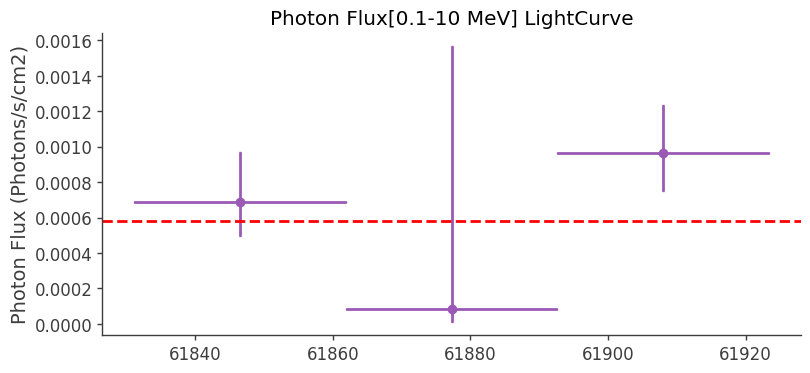

In [15]:
#
#Plot the time series of counts and fluxes
#
time_mjd=Time(time,format='unix').mjd
tmeds_mjd=Time(tmeds_lc, format='unix').mjd
e_tmeds_mjd=TimeDelta(e_tmeds_lc, format='sec').to('day').value
simulated_flux=np.mean(fls)

cm = 1/2.54
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(21*cm, 9.9*cm))
#
# Photon Flux Lightcurve
axs.errorbar(tmeds_mjd, fls, xerr=e_tmeds_mjd, yerr=[e_low_fls,e_hi_fls],fmt='o', capsize=1)
axs.set_title('Photon Flux[0.1-10 MeV] LightCurve')
axs.set_ylabel('Photon Flux (Photons/s/cm2)')
axs.axhline(y=np.mean(fls), color='red', linestyle='--')
#
# Photon Flux Lightcurve
# Adjust spacing between subplots
plt.tight_layout()
# plt.savefig("eqslice_raw_flux_counts_lc.pdf", dpi=300)
os.makedirs("plots", exist_ok=True)  # Create directory first
# plt.savefig(f"plots/photonflux_lc.png", dpi=300, bbox_inches='tight')
    

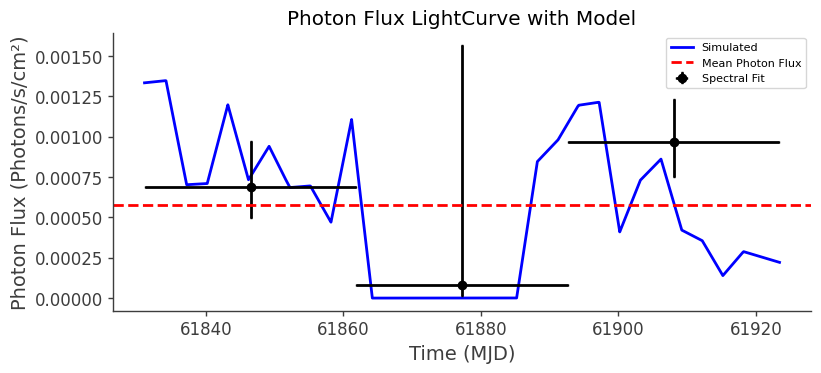

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import astropy.units as u
import os

# === Load and process the first light curve ===
time_l = []
norm = []
with open('./4C_21_lightcurve_noflare.dat', 'r') as file:
    lines = file.readlines()

for line in lines[2:]:
    tokens = line.split()
    if len(tokens) >= 3:
        try:
            value1 = float(tokens[1])
            value2 = float(tokens[2])
            time_l.append(value1)
            norm.append(value2)
        except ValueError:
            continue

dt = time_l[-1] - time_l[0]
I = np.trapz(norm, time_l)
avg_norm = I / dt

flux = 0.0005535336768481181 
fact = flux / avg_norm
norm = np.array(norm)
flux_i = norm * fact

start_unix_time_val = time_l[0]
start_time = Time(start_unix_time_val, format='unix', scale='utc')
time_deltas = TimeDelta(time_l * u.s)
absolute_times = start_time + time_deltas
mjd_values = Time(time_l, format='unix').mjd

# === Simulated photon flux lightcurve data ===
# Make sure the following variables are already defined:
# `time`, `tmeds_lc`, `e_tmeds_lc`, `fls`, `e_low_fls`, `e_hi_fls`

time_mjd = Time(time, format='unix').mjd
tmeds_mjd = Time(tmeds_lc, format='unix').mjd
e_tmeds_mjd = TimeDelta(e_tmeds_lc, format='sec').to('day').value
simulated_flux = np.mean(fls)

# === Combined Plot ===
cm = 1/2.54
fig, ax = plt.subplots(figsize=(21*cm, 9.9*cm))

# Plot the original normalized lightcurve converted to flux
ax.plot(mjd_values, flux_i, label="Simulated", color='blue')

# Plot the simulated flux lightcurve with error bars
ax.errorbar(tmeds_mjd, fls, xerr=e_tmeds_mjd, yerr=[e_low_fls, e_hi_fls],
            fmt='o', capsize=1, label="Spectral Fit", color='black')

# Plot the mean flux line
ax.axhline(y=simulated_flux, color='red', linestyle='--', label='Mean Photon Flux')

# Add labels and legend
ax.set_title('Photon Flux LightCurve with Model')
ax.set_ylabel('Photon Flux (Photons/s/cm²)')
ax.set_xlabel('Time (MJD)')
ax.legend()

plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("combined_flux_lightcurve.png", dpi=300, bbox_inches='tight')
plt.show()
